In [1]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [15]:
def train_test_open(path_to_data):
    times = ['time%i' % i for i in range(1,11)]
    train_df = pd.read_csv(path_to_data + 'train_sessions.csv',
                       index_col='session_id', parse_dates=['ti'])
    test_df = pd.read_csv(path_to_data + 'test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])
    train_df = train_df.sort_values(by='time1')
    return train_df, test_df

In [17]:
train_df, test_df = train_test_open(PATH_TO_DATA)

In [18]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [33]:
times = ['time%i' % i for i in range(1,11)]
sites = ['site%i' % i for i in range(1,11)]

In [40]:
train_time_df = pd.DataFrame(data = train_df[times], columns = times)
test_time_df = pd.DataFrame(data = test_df[times], columns = times)

In [41]:
train_time_df['target'] = train_df.target

In [51]:
#train_sites_df = pd.DataFrame(data = train_df[sites], columns = times)

In [ ]:
#train_sites_df['N_sites'] = train_sites_df.

In [52]:
number_of_sites = train_time_df.isna().sum(axis=1).values.reshape(-1, 1)

In [53]:
number_of_sites

array([[8],
       [6],
       [0],
       ...,
       [0],
       [0],
       [3]], dtype=int64)

In [62]:
plt.figure(figsize = (15, 10))
#plt.plot(train_time_df.time1.dt.month, number_of_sites)
times.time1.plot()

AttributeError: 'list' object has no attribute 'time1'

<Figure size 1080x720 with 0 Axes>

In [65]:
train_time_df.groupby(['time1']).count().head(4)

,time2,time3,time4,time5,time6,time7,time8,time9,time10,target
time1,,,,,,,,,,
2013-01-12 08:05:57,1,0,0,0,0,0,0,0,0,1
2013-01-12 08:37:23,1,1,1,0,0,0,0,0,0,1
2013-01-12 08:50:13,1,1,1,1,1,1,1,1,1,1
2013-01-12 08:50:17,1,1,1,1,1,1,1,1,1,1


In [73]:
np.dtype(train_time_df.time1.values[0])

dtype('<M8[ns]')

In [79]:
str(train_time_df.time1.values[0])

'2013-01-12T08:05:57.000000000'

In [98]:
#x = [str(i.) for i in train_time_df.time1]
year = train_time_df.time1.dt.year
month = train_time_df.time1.dt.month
day = train_time_df.time1.dt.day

x = [str(i)+'-'+str(j)+'-'+str(k) for i, j, k in list(zip(year, month, day))]

In [100]:
train_time_df['date'] = x


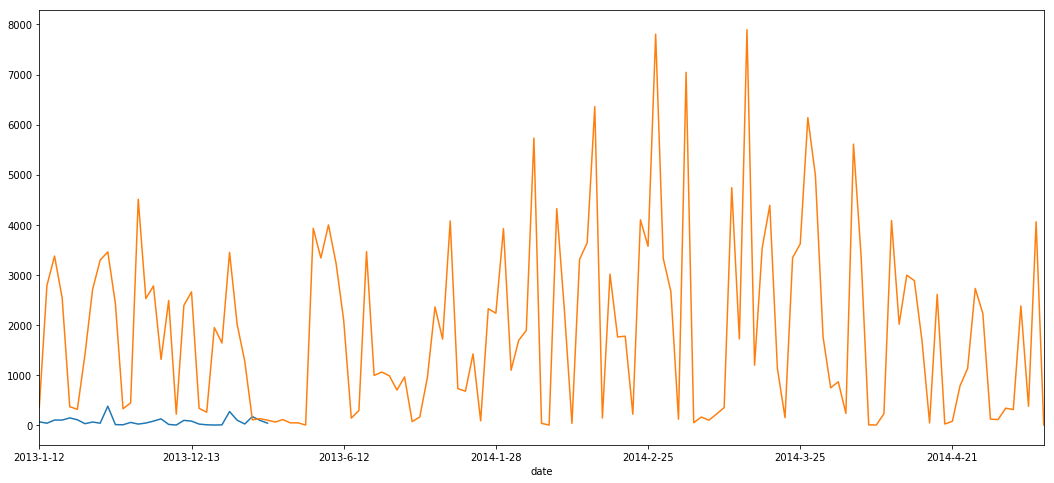

In [126]:
N_sessions_perday = train_time_df.groupby(['date']).count()['time1']
N_sessions_perday_Alice = train_time_df[train_time_df['target'] == 1].groupby(['date']).count()['time1']
plt.figure(figsize = (18, 8))
#N_sessions_perday.plot()
#plt.xticks(x, labels, rotation='vertical')
#plt.xticks(rotation=70)
N_sessions_perday_Alice.plot()
N_sessions_perday.plot()

In [111]:
train_time_df['date'].groupby(['date']).count().head()

KeyError: 'date'

In [ ]:
plt.plot(train_time_df['date'], 

## Minutes

In [42]:
train_minute = train_time_df.time1.dt.minute
test_minute = test_time_df.time1.dt.minute

In [144]:
for i in range(2, 11):
    train_df['time{}'.format(i)] = pd.to_datetime(train_df['time{}'.format(i)])
for i in range(2, 11):
    test_df['time{}'.format(i)] = pd.to_datetime(test_df['time{}'.format(i)])

In [145]:
train_times, test_times = train_df[times], test_df[times]
train_sites, test_sites = train_df[sites], test_df[sites]

In [146]:
hour = train_times['time1'].apply(lambda ts: ts.hour)

In [176]:
#durations = (train_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int) **0.2
difference = (train_times.max(axis=1) - train_times.min(axis=1))
durations = [int(difference.iloc[i].total_seconds()) for i in range(len(difference))]


(array([208802.,  19296.,   6948.,   4597.,   3341.,   2505.,   2232.,
          1730.,   1668.,   2442.]),
 array([   0.,  180.,  360.,  540.,  720.,  900., 1080., 1260., 1440.,
        1620., 1800.]),
 <a list of 10 Patch objects>)

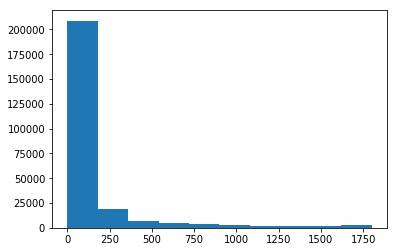

In [181]:
plt.hist(durations)

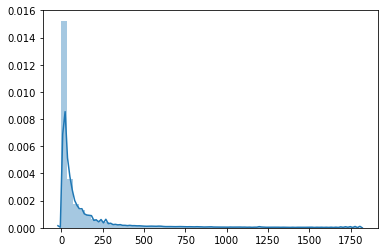

In [196]:
sns.distplot(durations)

In [203]:
max(durations)

1800

In [190]:
x = train_df.time1.dt.date.values

array([datetime.date(2013, 1, 12), datetime.date(2013, 1, 12),
       datetime.date(2013, 1, 12), ..., datetime.date(2014, 4, 30),
       datetime.date(2014, 4, 30), datetime.date(2014, 4, 30)],
      dtype=object)

(array([ 4292.,  7334.,  3229.,  2233.,   290.,  6252., 34493., 40272.,
        73345., 81821.]),
 array([734880.33746528, 734927.70232176, 734975.06717824, 735022.43203472,
        735069.7968912 , 735117.16174769, 735164.52660417, 735211.89146065,
        735259.25631713, 735306.62117361, 735353.98603009]),
 <a list of 10 Patch objects>)

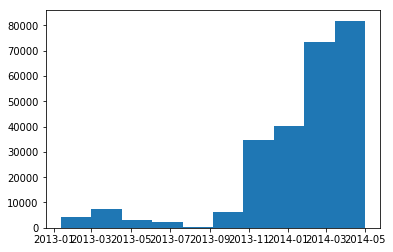

In [193]:
plt.hist(x)

TypeError: ufunc add cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

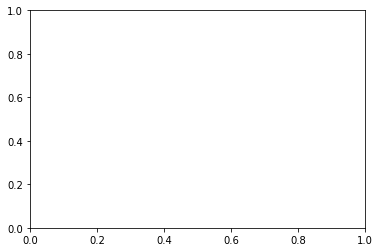

# Create new features for correlation analysis

In [311]:
hour = train_times['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11)).astype('int').values#.reshape(-1, 1)
day = ((hour >= 12) & (hour <= 18)).astype('int').values#.reshape(-1, 1)
evening = ((hour >= 19) & (hour <= 23)).astype('int').values#.reshape(-1, 1)
night = ((hour >= 0) & (hour <=6)).astype('int').values#.reshape(-1, 1)

In [312]:
# day of the week and month and year and summer
day_of_week = train_times['time1'].apply(lambda t: t.weekday()).values#.reshape(-1, 1)
day_of_month = train_times['time1'].dt.day.values#.reshape(-1, 1)
month = train_times['time1'].apply(lambda t: t.month).values#.reshape(-1, 1) 
summer = ((month >= 6) & (month <= 8)).astype('int')#.reshape(-1, 1)
year = train_times['time1'].dt.year.values#.reshape(-1, 1)

In [313]:
# linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
year_month = train_times['time1'].apply(lambda t: 100 * t.year + t.month).values#.reshape(-1, 1)

In [314]:
holiday = ((day_of_week >= 5) & (day_of_week <= 7)).astype('int')#.reshape(-1, 1)
minute = train_times['time1'].dt.minute.values#.reshape(-1, 1)

In [356]:
minute

array([ 5, 37, 50, ..., 38, 38, 39], dtype=int64)

In [315]:
difference = (train_times.max(axis=1) - train_times.min(axis=1))
durations = [int(difference.iloc[i].total_seconds()) for i in range(len(difference))]


In [316]:
durations[0:5]

[0, 1786, 4, 3, 2]

In [317]:
train_times.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


In [318]:
N_sites = (train_times.isnull().sum(axis=1)).apply(lambda x: 10 - x).values#.reshape(-1, 1)

In [319]:
N_sites

array([ 2,  4, 10, ..., 10, 10,  7], dtype=int64)

In [320]:
#durations = np.reshape(durations, (-1, 1))
durations

[0,
 1786,
 4,
 3,
 2,
 3,
 3,
 3,
 5,
 27,
 31,
 50,
 42,
 16,
 92,
 1189,
 510,
 1278,
 39,
 257,
 209,
 90,
 1370,
 0,
 365,
 30,
 142,
 23,
 46,
 66,
 68,
 0,
 151,
 95,
 143,
 936,
 310,
 0,
 21,
 311,
 110,
 11,
 1001,
 570,
 1,
 3,
 125,
 548,
 1749,
 110,
 81,
 83,
 682,
 93,
 23,
 0,
 471,
 1440,
 138,
 298,
 306,
 184,
 1340,
 115,
 0,
 78,
 8,
 811,
 0,
 0,
 0,
 961,
 10,
 72,
 51,
 1396,
 270,
 360,
 0,
 1170,
 4,
 3,
 1,
 2,
 8,
 8,
 665,
 538,
 0,
 1,
 1,
 2,
 3,
 1272,
 116,
 1512,
 348,
 0,
 116,
 116,
 168,
 756,
 6,
 55,
 242,
 185,
 18,
 14,
 16,
 25,
 162,
 611,
 53,
 10,
 69,
 1714,
 744,
 2,
 1,
 2,
 4,
 8,
 590,
 1,
 46,
 1,
 2,
 368,
 3,
 178,
 294,
 248,
 132,
 6,
 30,
 34,
 14,
 5,
 3,
 10,
 87,
 2,
 178,
 230,
 2,
 1,
 2,
 7,
 7,
 587,
 49,
 683,
 65,
 153,
 698,
 1655,
 1705,
 1768,
 140,
 99,
 21,
 222,
 7,
 16,
 85,
 7,
 10,
 17,
 4,
 48,
 0,
 1334,
 0,
 334,
 1179,
 1732,
 12,
 58,
 58,
 1752,
 36,
 2,
 2,
 6,
 2,
 1,
 61,
 32,
 66,
 71,
 71,
 4,
 3,
 31,

In [321]:
time_for_site = [0 if int(N_sites[i]) == 0 else int(durations[i])/int(N_sites[i]) for i in range(len(durations))]

In [322]:
#time_for_site = np.reshape(time_for_site, (-1, 1))
time_for_site[0:10]

[0.0, 446.5, 0.4, 0.3, 0.2, 0.3, 0.3, 0.3, 0.5, 2.7]

In [323]:
time_features = [hour, morning, day, evening, night, day_of_week, day_of_month, month, summer, year, year_month, holiday, 
                 minute, durations, time_for_site]
time_feature_names = ['hour', 'morning', 'day', 'evening', 'night', 'day_of_week', 'day_of_month', 'month', 'summer', 'year',
                      'year_month', 'holiday', 'minute', 'durations', 'time_for_site']

In [343]:
#df = pd.DataFrame(data = [hour], columns = ['hour'], index = train_times.index)

In [344]:
df = pd.DataFrame()

In [345]:
#df['hour'] = hour

In [346]:
for i in range(len(time_features)):
    df[time_feature_names[i]] = time_features[i]

In [347]:
df.head(5)

,hour,morning,day,evening,night,day_of_week,day_of_month,month,summer,year,year_month,holiday,minute,durations,time_for_site
session_id,,,,,,,,,,,,,,,
21669,8,1,0,0,0,5,12,1,0,2013,201301,1,5,0,0.0
54843,8,1,0,0,0,5,12,1,0,2013,201301,1,37,1786,446.5
77292,8,1,0,0,0,5,12,1,0,2013,201301,1,50,4,0.4
114021,8,1,0,0,0,5,12,1,0,2013,201301,1,50,3,0.3
146670,8,1,0,0,0,5,12,1,0,2013,201301,1,50,2,0.2


In [349]:
df['target'] = train_df.target

In [354]:
df = df.drop(['night'], axis = 1)

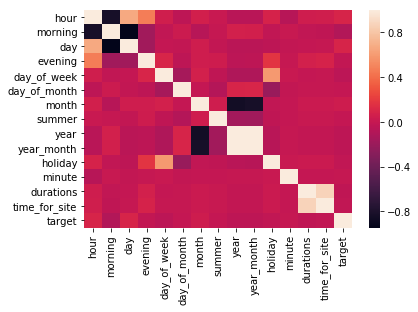

In [355]:
sns.heatmap(df.corr())